In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm  
import random

Eurobusiness is a board game where we have 40 fields. 1 is the starting field and 40 is Vienna. The player throws two dice, if the numbers on the dice are different, the player moves forward by the sum of the numbers. Otherwise, the player rolls again and if the dice return the same number, player goes to prison. During the course of the game, we also have spy cards that cause a change of position. 
Blue cards are in the filds 3, 18 and 34, the red cards are in the filds 8,23,37. Among the blue cards are three position-shifting ones: "go to start", "go to prison", "go to Vienne". Among the red cards there are seven cards that can change the position: "return to start", "go to Naples", "go to prison", "return to Madrid", "return to Brussels", "go to the Eastern Railway" and "go back three fields". There are 16 cards in each card group.

Our task is to find the field with the highest probability of being visited using the Monte Carlo method.

In [95]:
class eurobusiness:
    def __init__(self, N):
        self.N = N
        
    def model_without_extra_cards(self):
        ''' The basic model where we do not consider additional cards, which can change our position'''
        
        boxes_on_the_board = np.zeros(40) #vector where we will count how many times visit each boxes
        position = 1 #start
        boxes_on_the_board[0] = 1 #at the beginning we are on start
        for i in tqdm(range(self.N)):
            first_throw = random.randrange(1,7,1)
            second_throw = random.randrange(1,7,1)
            if first_throw != second_throw:
                position = position + first_throw + second_throw
            else:
                first_throw = random.randrange(1,7,1)
                second_throw = random.randrange(1,7,1)
                if first_throw != second_throw:
                    position = position + first_throw + second_throw
                else:
                    position = 11 #go to prison
            
            position = position % 40
            if position == 0: # when we go to meta, boxes 40
                position = 40
            else:
                boxes_on_the_board[position] += 1
        probabilities = [box / self.N for box in boxes_on_the_board]       
        return boxes_on_the_board, probabilities
    
    def change_position(self, p):
        ''' Function return the position of player after draw red/blue card'''
        cards = list(range(1,33))
        position = p%40
        if position == 0:
            position = 39
        elif position == 31:
            position = 11 #go to prison
        elif position in [3,18,34]: # blue cards, 12 when we have situations pay or draw from red cards
            card = random.choice(cards)
            # if we draw card nr 12 we have a choice
            p = random.random()
            if (card == 12 and p <= 0.5):
                # if it is true we draw from red cards 
                position = random.choices([position, 1, 7, 11, 15, 24, 36], weights=[10/16, 1/16, 1/16, 1/16, 1/16, 1/16, 1/16], k=1)[0]
                if position == 0 or position == 40:
                    position = 39
            else:
                position = random.choices([position, 1, 11, 40], weights=[13/16, 1/16, 1/16, 1/16], k=1)[0]
                if position == 0 or position == 40:
                    position = 39
        elif position in [8, 23, 37]: # red cards
            position = random.choices([position, 1, 7, 11, 15, 24, 36], weights=[10/16, 1/16, 1/16, 1/16, 1/16, 1/16, 1/16], k=1)[0]
            if position == 0 or position == 40:
                position = 39

        
        return position
    
    def model_with_extra_cards(self):
        ''' Consider the model where we can draw cards. Due to this we can change our position
            31 - go to prison
            3,18,34 - blue card 
            8, 23, 37 - red cards
            In blue cards we have three which change the position, it means that we have prob.13/16 not to change the position
            or with prob. 1/16 we can move to boxes 1, 11, 40 
            In red cards: with prob. 10/16 does not change position, with prob. 1/16 we can move to boxes 1,7,11,15,24,36
        '''
        boxes_on_the_board = np.zeros(40) #vector where we will count how many times visit each boxes
        position = 1 #start
        boxes_on_the_board[0] = 1 #at the beginning we are on start
        for i in tqdm(range(self.N)):
            first_throw = random.randrange(1,7,1)
            second_throw = random.randrange(1,7,1)
            if first_throw != second_throw:
                position = position + first_throw + second_throw
            else:
                first_throw = random.randrange(1,7,1)
                second_throw = random.randrange(1,7,1)
                if first_throw != second_throw:
                    position = position + first_throw + second_throw
                else:
                    position = 11 #go to prison
                    
            p = self.change_position(position)
            boxes_on_the_board[p] += 1
        probabilities = [box / self.N for box in boxes_on_the_board]       
        return boxes_on_the_board, probabilities       

In [96]:
player = eurobusiness(1000000)
results1, prob1 = player.model_without_extra_cards()
results2, prob2 = player.model_with_extra_cards()

100%|████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:02<00:00, 414759.79it/s]


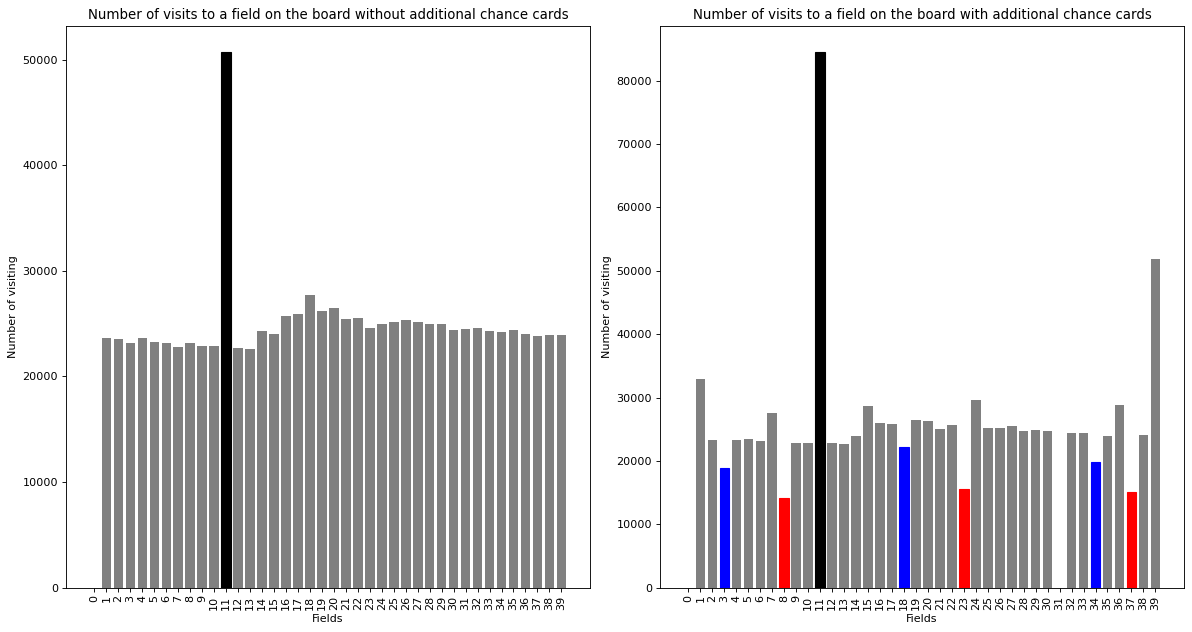

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8), dpi=80)

p = axs[0].bar(np.arange(len(results1)), results1, color="grey")
p[11].set_color("k") #set black to prison 
axs[0].set_title("Number of visits to a field on the board without additional chance cards")
axs[0].set_xlabel("Fields")
axs[0].set_ylabel("Number of visiting")
axs[0].set_xticks(np.arange(len(results1)))
axs[0].set_xticklabels(np.arange(len(results1)), rotation="vertical")

p2 = axs[1].bar(np.arange(len(results2)), results2, color="grey")
p2[11].set_color("k") #set black to prison
p2[8].set_color("r") #red cards
p2[23].set_color("r") #red cards
p2[37].set_color("r") #red cards
p2[3].set_color("b") #blue cards
p2[18].set_color("b") #blue cards
p2[34].set_color("b") #blue cards
axs[1].set_title("Number of visits to a field on the board with additional chance cards")
axs[1].set_xlabel("Fields")
axs[1].set_ylabel("Number of visiting")
axs[1].set_xticks(np.arange(len(results2)))
axs[1].set_xticklabels(np.arange(len(results2)), rotation="vertical")

plt.tight_layout()

plt.show()

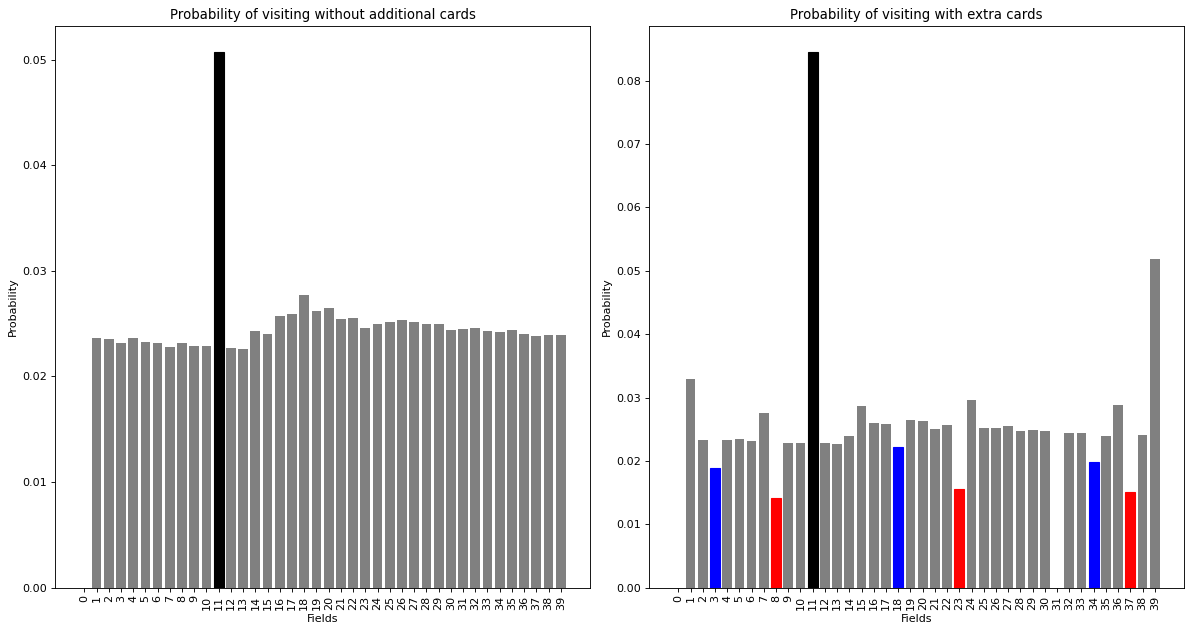

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8), dpi=80)

p = axs[0].bar(np.arange(len(prob1)), prob1, color="grey")
p[11].set_color("k") #set black to prison 
axs[0].set_title("Probability of visiting without additional cards")
axs[0].set_xlabel("Fields")
axs[0].set_ylabel("Probability")
axs[0].set_xticks(np.arange(len(prob1)))
axs[0].set_xticklabels(np.arange(len(prob1)), rotation="vertical")

p2 = axs[1].bar(np.arange(len(prob2)), prob2, color="grey")
p2[11].set_color("k") #set black to prison
p2[8].set_color("r") #red cards
p2[23].set_color("r") #red cards
p2[37].set_color("r") #red cards
p2[3].set_color("b") #blue cards
p2[18].set_color("b") #blue cards
p2[34].set_color("b") #blue cards
axs[1].set_title("Probability of visiting with extra cards")
axs[1].set_xlabel("Fields")
axs[1].set_ylabel("Probability")
axs[1].set_xticks(np.arange(len(prob2)))
axs[1].set_xticklabels(np.arange(len(prob2)), rotation="vertical")

plt.tight_layout()

plt.show()

In [109]:
prob2_copy = np.copy(prob2)
dictionary = {index: number for index, number in enumerate(prob2_copy)}
dictionary_copy = dictionary.copy()
keys_to_remove = [11,8,23,37,3,18,34]
for key in keys_to_remove:
    if key in dictionary:
        del dictionary[key]
sorted_dict = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))
df = pd.DataFrame(list(sorted_dict.items()), columns=['Fields', 'Probability'])

In [113]:
top = df[0:10]
print(top)

   Fields  Probability
0      39     0.051933
1       1     0.032896
2      24     0.029663
3      36     0.028810
4      15     0.028590
5       7     0.027571
6      19     0.026514
7      20     0.026299
8      16     0.026015
9      17     0.025850


39 - enrichment field;
1 - start;
24 - Brussels;
36 - Eastern Railway;
15 - Madrid;
7 - Naples;
19 - Glasgou;
20 - London;
16 - Western Railway;
17 - Liverpool;

In [118]:
fields_to_remove = [39,1,36,16] #because there are not cities
top_cleared = top[~top['Fields'].isin(fields_to_remove)]
print(top_cleared)

   Fields  Probability
2      24     0.029663
4      15     0.028590
5       7     0.027571
6      19     0.026514
7      20     0.026299
9      17     0.025850


# Result 

The most profitable cities to buy are Brussels, Madrid, Naples, Glasgou, London and Liverpool